In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


# Import session

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import imgaug.augmenters as iaa
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import tqdm
import tqdm.notebook as tqdm
from torch.nn.utils import clip_grad_norm_
import time
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import textwrap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss, classification_report


# Prepare Data

In [3]:
train_df = pd.read_csv('./data/allergens_train.csv')
val_df = pd.read_csv('./data/allergens_val.csv')
test_df = pd.read_csv('./data/allergens_test.csv')
columns_to_drop = ['target', 'class_id']
train_df = train_df.drop(columns_to_drop, axis=1)
val_df = val_df.drop(columns_to_drop, axis=1)
test_df = test_df.drop(columns_to_drop, axis=1)
allergens = train_df.columns[4:]
train_df

path class_name  \
0      ../archive/images/apple_pie/1005649.jpg  apple_pie   
1      ../archive/images/apple_pie/1014775.jpg  apple_pie   
2      ../archive/images/apple_pie/1026328.jpg  apple_pie   
3      ../archive/images/apple_pie/1028787.jpg  apple_pie   
4      ../archive/images/apple_pie/1043283.jpg  apple_pie   
...                                        ...        ...   
68170     ../archive/images/waffles/981485.jpg    waffles   
68171      ../archive/images/waffles/98238.jpg    waffles   
68172     ../archive/images/waffles/982668.jpg    waffles   
68173     ../archive/images/waffles/995085.jpg    waffles   
68174     ../archive/images/waffles/999047.jpg    waffles   

                                             ingredients  \
0      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
1      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
2      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
3      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
4      ['butter', 'flour', 'sugar', 'brown sugar', 'a...   
...                                                  ...   
68170  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   
68171  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   
68172  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   
68173  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   
68174  ['egg', 'salt', 'sugar', 'vanilla', 'butter', ...   

                                 allergens  sugar  apple  butter  lemon  \
0             ['sugar', 'apple', 'butter']      1      1       1      0   
1             ['sugar', 'apple', 'butter']      1      1       1      0   
2             ['sugar', 'apple', 'butter']      1      1       1      0   
3             ['sugar', 'apple', 'butter']      1      1       1      0   
4             ['sugar', 'apple', 'butter']      1      1       1      0   
...                                    ...    ...    ...     ...    ...   
68170  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   
68171  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   
68172  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   
68173  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   
68174  ['butter', 'eggs', 'sugar', 'milk']      1      0       1      0   

       honey  sweet pepper  ...  sweet potato  potato  celery  rice  cherry  \
0          0             0  ...             0       0       0     0       0   
1          0             0  ...             0       0       0     0       0   
2          0             0  ...             0       0       0     0       0   
3          0             0  ...             0       0       0     0       0   
4          0             0  ...             0       0       0     0       0   
...      ...           ...  ...           ...     ...     ...   ...     ...   
68170      0             0  ...             0       0       0     0       0   
68171      0             0  ...             0       0       0     0       0   
68172      0             0  ...             0       0       0     0       0   
68173      0             0  ...             0       0       0     0       0   
68174      0             0  ...             0       0       0     0       0   

       salmon  cabbage  duck  orange  strawberry  
0           0        0     0       0           0  
1           0        0     0       0           0  
2           0        0     0       0           0  
3           0        0     0       0           0  
4           0        0     0       0           0  
...       ...      ...   ...     ...         ...  
68170       0        0     0       0           0  
68171       0        0     0       0           0  
68172       0        0     0       0           0  
68173       0        0     0       0           0  
68174       0        0     0       0           0  

[68175 rows x 37 columns]

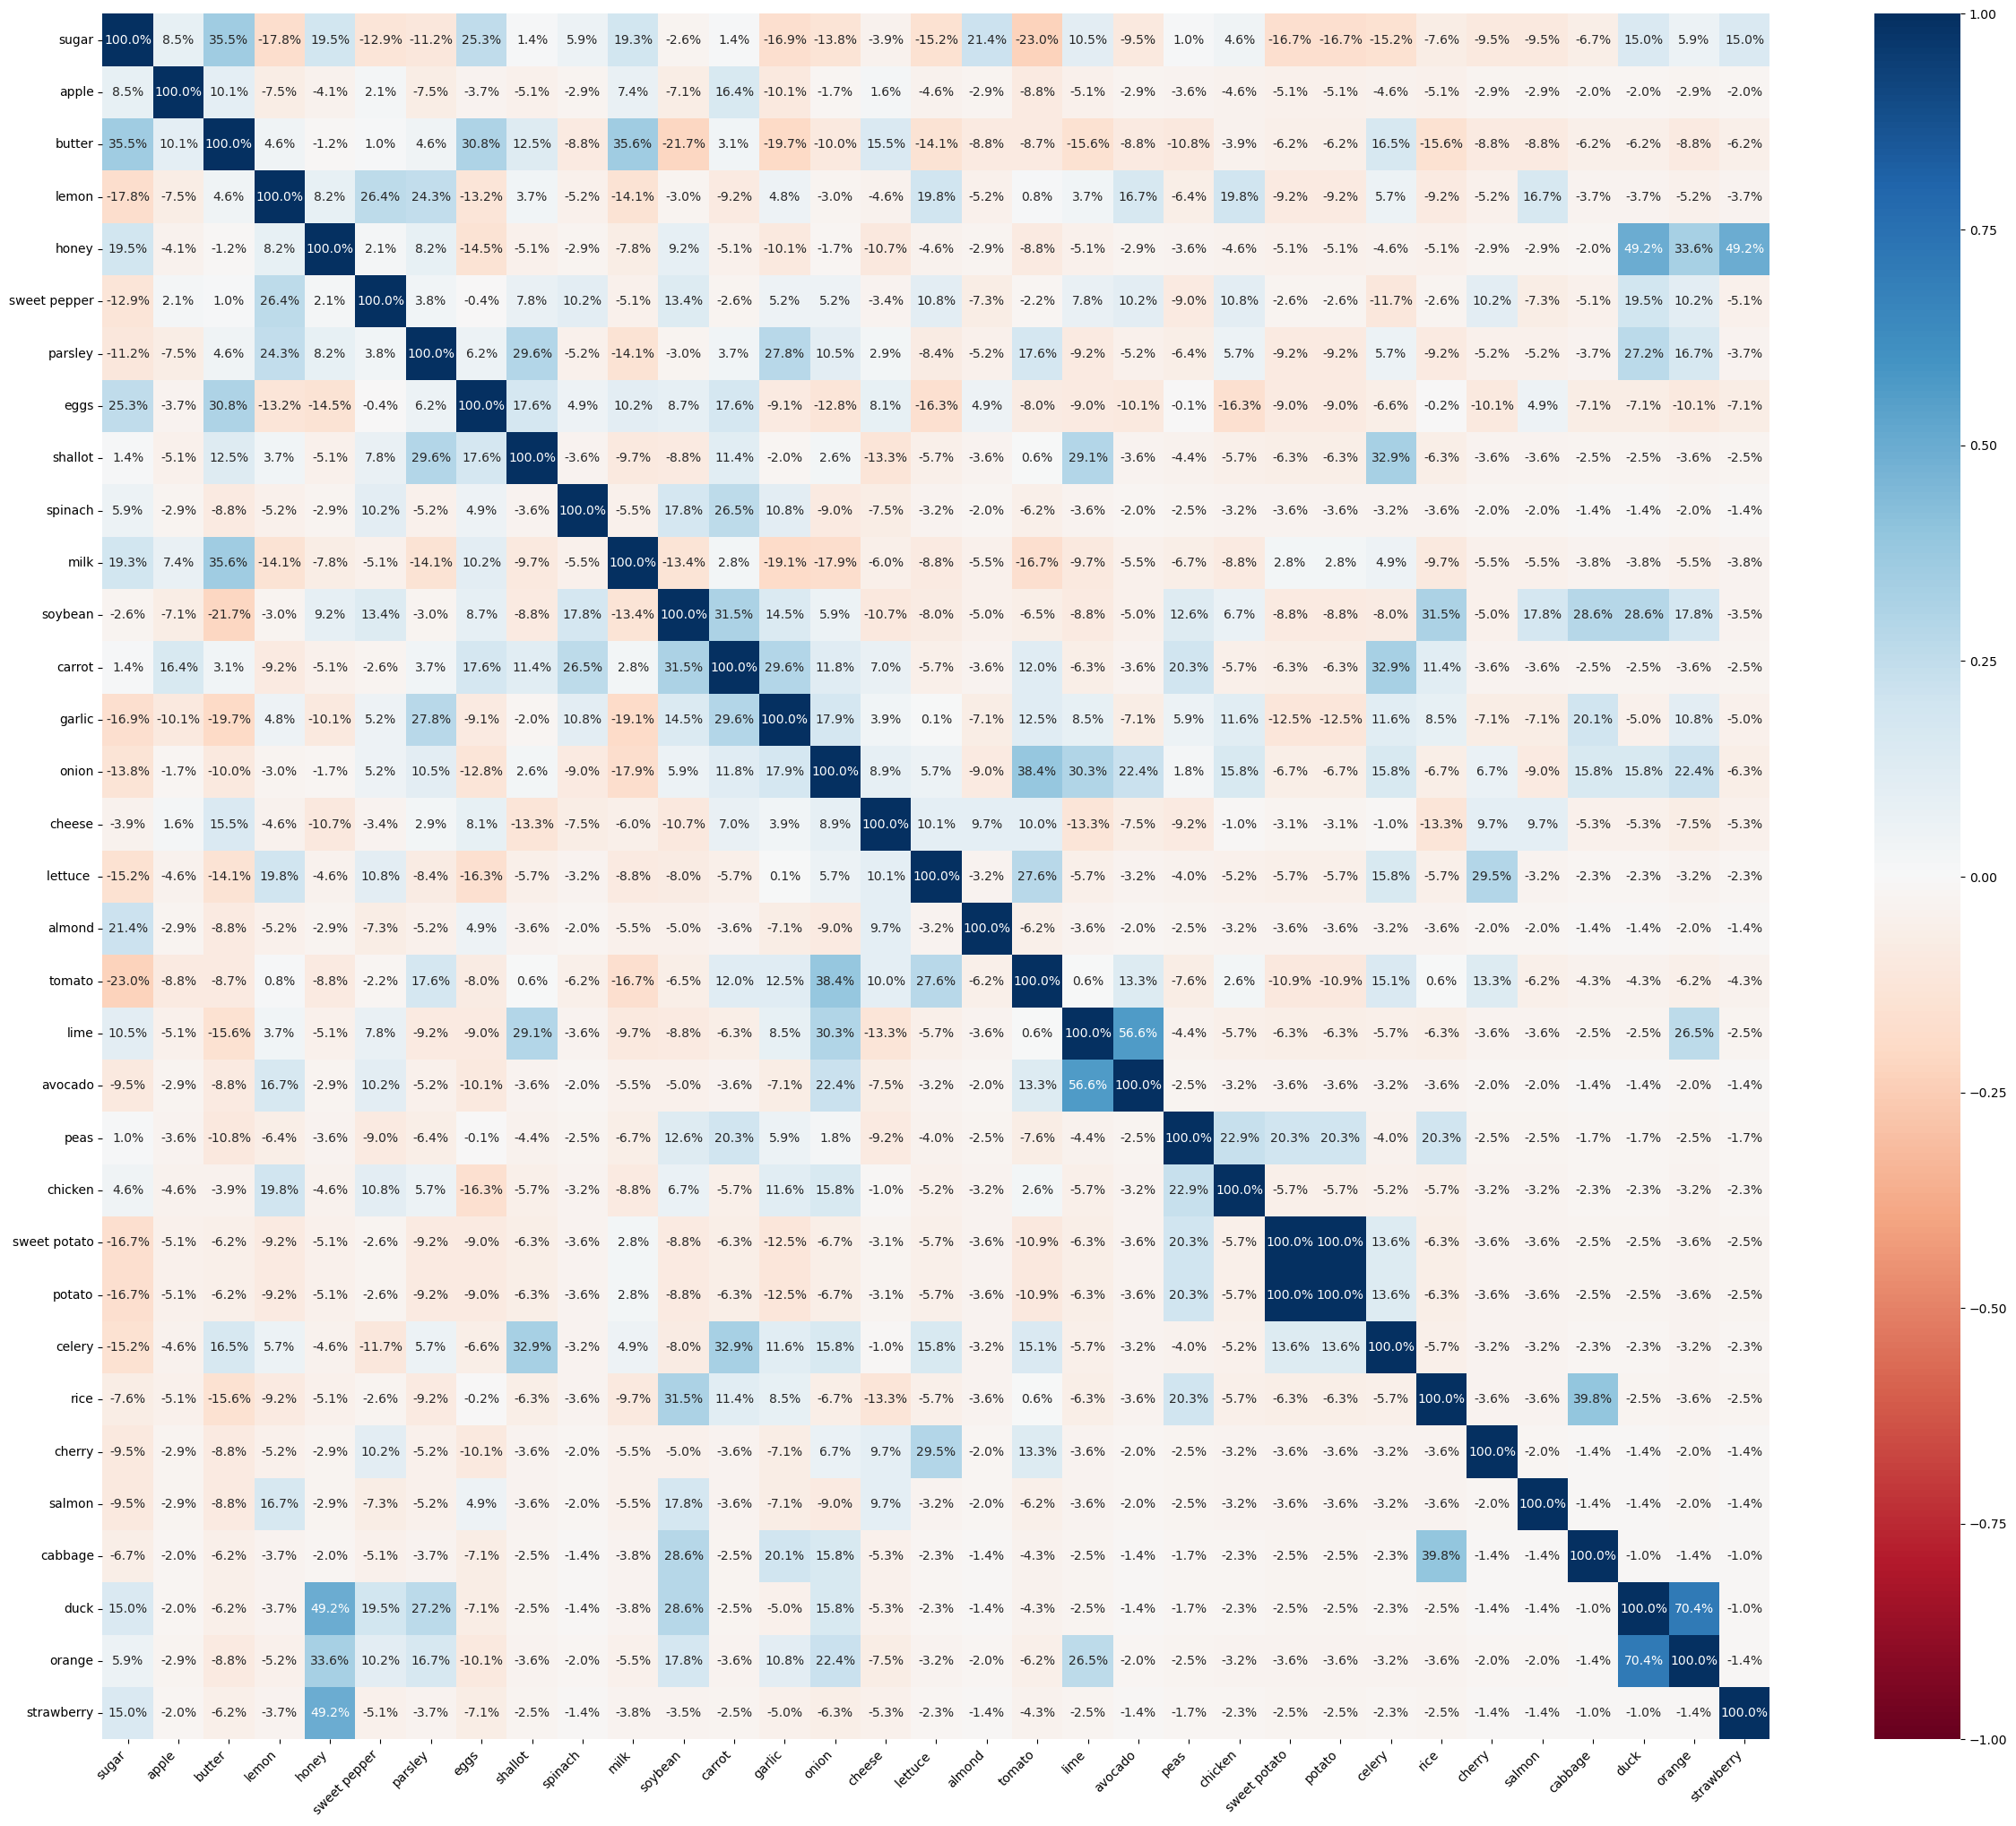

In [4]:
mapped_data = train_df[allergens].apply(lambda x: x.map(lambda val: 1 if val > 0 else 0)).values
mapped_data = mapped_data.T
co_all = np.corrcoef(mapped_data)

fig, ax1 = plt.subplots(1, 1, figsize=(30, 25))
heatmap = sns.heatmap(co_all, annot=True, fmt='2.1%', ax=ax1, cmap='RdBu', vmin=-1, vmax=1)

ax1.set_xticklabels(allergens, rotation=45, ha='right')
ax1.set_yticklabels(allergens, rotation=0, ha='right')
plt.show()


# Preprocessing data

In [11]:
image_size = (224, 224)

class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, augmentation=None):
        self.dataframe = dataframe
        self.transform = transform
        self.augmentation = augmentation

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)
        label = torch.Tensor(self.dataframe.iloc[idx, 4:].values.astype(float))

        if image.mode != "RGB":
            image = image.convert("RGB")

        if self.augmentation:
            image_np = np.array(image)
            augmented_image_np = self.augmentation(images=[image_np])[0]
            image = Image.fromarray(augmented_image_np)

        if self.transform:
            image = self.transform(image)

        image = torch.Tensor(image)
        label = torch.Tensor(label)

        return image, label

augmentation = iaa.Sequential([
    iaa.Fliplr(0.5),
    iaa.Crop(percent=(0, 0.2)),
    iaa.Sometimes(0.5, iaa.GaussianBlur(sigma=(0, 0.5))),
    iaa.ContrastNormalization((0.75, 1.5)),
    iaa.AdditiveGaussianNoise(loc=0, scale=(0.2, 0.05 * 255), per_channel=0.5),
    iaa.Multiply((0.8, 1.2), per_channel=0.2),
    iaa.Affine(rotate=(-30, 30)),
])

train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.ColorJitter(brightness=(0.7, 1.3)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), shear=0.01, scale=(0.9, 1.25))
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
])

train_dataset = CustomDataset(dataframe=train_df, transform=train_transform, augmentation=augmentation)
val_dataset = CustomDataset(dataframe=val_df, transform=test_transform)
test_dataset = CustomDataset(dataframe=test_df, transform=test_transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


/Users/mac/anaconda3/lib/python3.11/site-packages/imgaug/imgaug.py:184: DeprecationWarning: Function `ContrastNormalization()` is deprecated. Use `imgaug.contrast.LinearContrast` instead.
  warn_deprecated(msg, stacklevel=3)


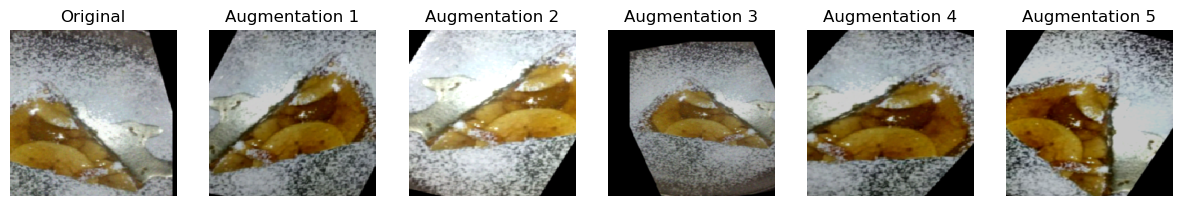

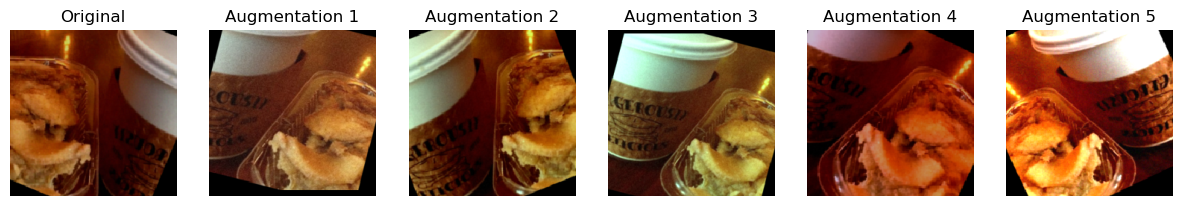

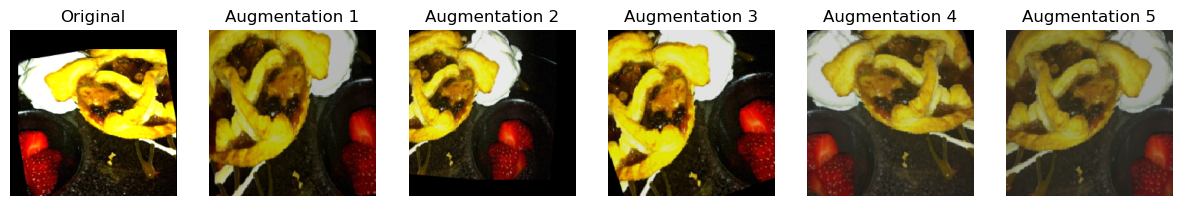

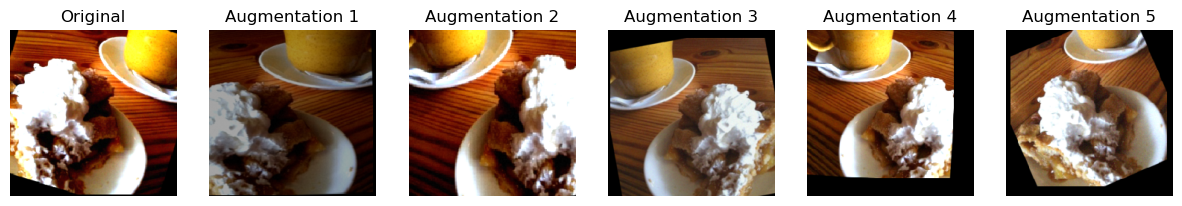

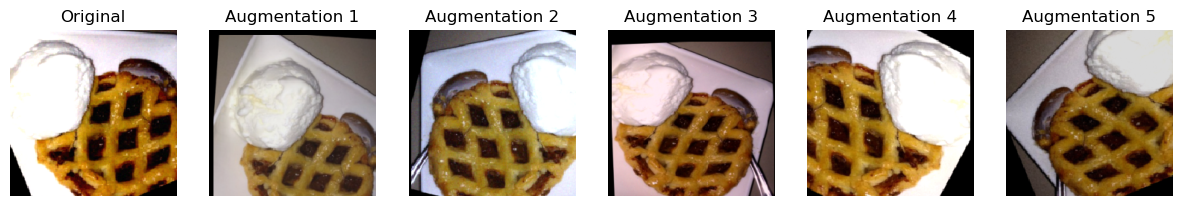

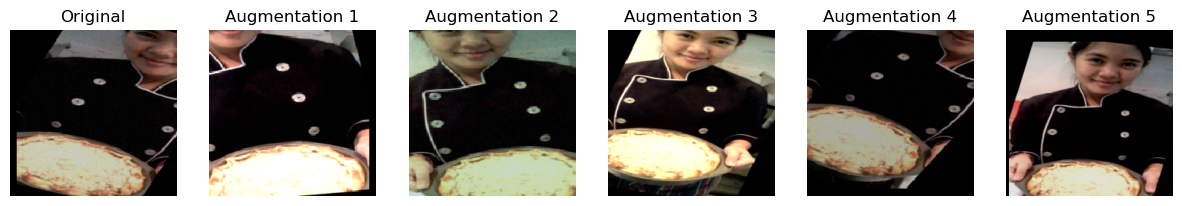

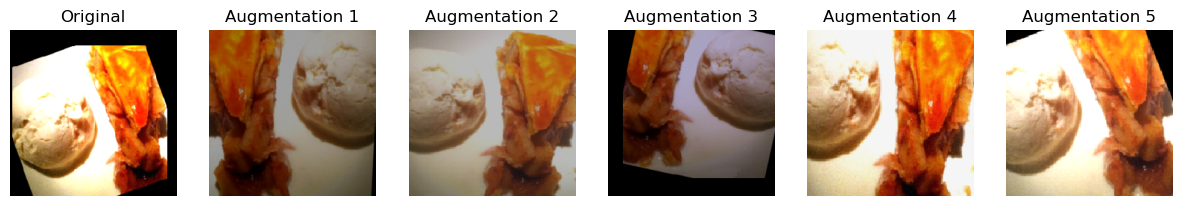

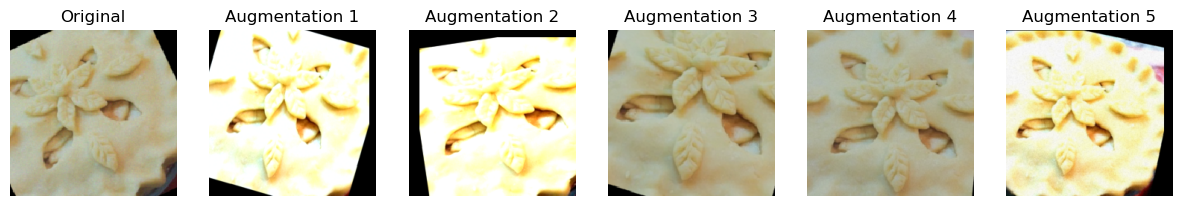

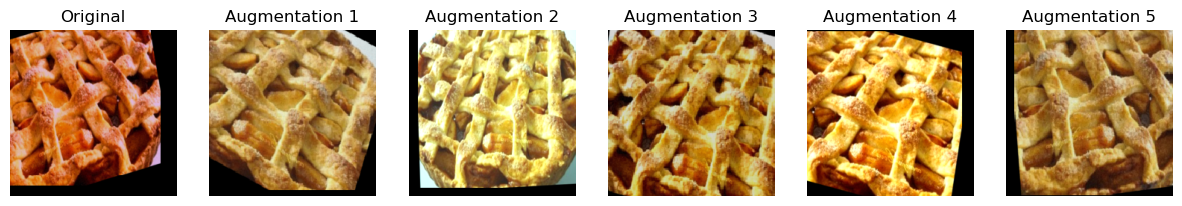

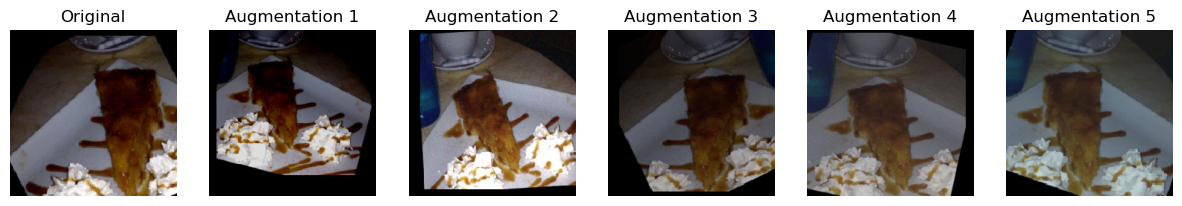

In [12]:
def show_augmentations(dataset, original_idx=0, num_augmentations=5):
    original_img, _ = dataset[original_idx]

    fig, axes = plt.subplots(1, num_augmentations + 1, figsize=(15, 3))

    # Display the original image
    axes[0].imshow(np.transpose(original_img.numpy(), (1, 2, 0)))
    axes[0].axis('off')
    axes[0].set_title('Original')

    # Display augmentations of the same image
    for i in range(1, num_augmentations + 1):
        augmented_img, _ = dataset[original_idx]
        axes[i].imshow(np.transpose(augmented_img.numpy(), (1, 2, 0)))
        axes[i].axis('off')
        axes[i].set_title(f'Augmentation {i}')

    plt.show()
for i in range(10):
    show_augmentations(train_dataset, original_idx=i, num_augmentations=5)


In [13]:
len(allergens)

33

# Train Model

In [14]:
# import torch
# import torch.nn as nn
# import torchvision.models as models

# class FineTunedResNet(nn.Module):
#     def __init__(self, num_classes=len(train_df.columns[6:])):
#         super(FineTunedResNet, self).__init__()
#         resnet = models.resnet18(pretrained=True)
#         self.features = nn.Sequential(*list(resnet.children())[:-1])
#         self.fc = nn.Linear(resnet.fc.in_features, num_classes)

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)
#         x = self.fc(x)
#         return x

# def Model():
#     return FineTunedResNet()

# model = Model()
# model.to(mps_device)


In [15]:
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes=len(allergens)):
        super(FineTunedResNet, self).__init__()
        resnet = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(resnet.children())[:-2])
        self.conv1x1 = nn.Conv2d(resnet.fc.in_features, 512, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.dropout = nn.Dropout(0.5)
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 512, kernel_size=1),
            nn.BatchNorm2d(512),
        )
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = self.conv1x1(x)
        x = self.bn1(x)
        x = F.relu(x, inplace=True)
        x = self.dropout(x)
        x = self.bottleneck(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

def Model():
    return FineTunedResNet()

model = Model()
model.to(mps_device)

/Users/mac/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/mac/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FineTunedResNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [16]:
def train_loop(train_loader, criterion, optimizer, train_loss, correct_train, total_train):
    for images, targets in tqdm.tqdm(train_loader, desc='Training'):
        images, targets = images.to(mps_device), targets.to(mps_device)
        optimizer.zero_grad()
        outputs = model(images)

        loss = criterion(outputs, targets)
        loss.backward()
        clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        train_loss += loss.item()

        total_batch = (targets.size(0) * targets.size(1))
        total_train += total_batch

        predicted_label = torch.sigmoid(outputs)>=0.5
        target_data = (targets==1.0)
        correct = torch.sum((predicted_label == target_data.to(mps_device)).to(torch.float)).item()
        correct_train += correct
    return train_loss, correct_train, total_train

def evaluate(val_loader, criterion, optimizer, val_loss, correct_val, total_val):
    model.eval()
    with torch.no_grad():
        for images, targets in val_loader:
            images, targets = images.to(mps_device), targets.to(mps_device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

            total_batch = (targets.size(0) * targets.size(1))
            total_val += total_batch

            predicted_label = torch.sigmoid(outputs)>=0.5
            target_data = (targets==1.0)
            correct = torch.sum((predicted_label == target_data.to(mps_device)).to(torch.float)).item()
            correct_val += correct
    return val_loss, correct_val, total_val

In [17]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
def train_ingredient_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    best_val_loss = float('inf')
    patience = 7
    no_improvement = 0
    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        val_loss = 0.0
        correct_val = 0
        total_val = 0

        train_loss, correct_train, total_train = train_loop(train_loader, criterion, optimizer, train_loss, correct_train, total_train)
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = (correct_train / total_train) * 100.0
        train_accuracies.append(train_accuracy)
        train_losses.append(avg_train_loss)

        val_loss, correct_val, total_val = evaluate(val_loader, criterion, optimizer, val_loss, correct_val, total_val)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = (correct_val / total_val) * 100.0
        val_accuracies.append(val_accuracy)
        val_losses.append(avg_val_loss)
        lr_scheduler.step(avg_val_loss)

        end_time = time.time()
        epoch_time = end_time - start_time

        print(f"Epoch [{epoch+1}/{num_epochs}] - Time: {epoch_time:.2f} seconds\n"
            f"Train Accuracy: {train_accuracy:.2f}% - Train Loss: {avg_train_loss:.4f}\n"
            f"Validation Accuracy: {val_accuracy:.2f}% - Validation Loss: {avg_val_loss:.4f}")
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement == patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

In [18]:
# labels = torch.tensor(train_df.iloc[:, 6:].values, dtype=torch.float32)
# class_frequencies = labels.sum(dim=0)

# total_samples = len(labels)
# class_weights = total_samples / (len(class_frequencies) * class_frequencies)

# class_weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(mps_device)

# criterion = nn.BCEWithLogitsLoss(weight=class_weight_tensor)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
# lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
# train_ingredient_model(model, train_loader, val_loader, criterion, optimizer, 30)

In [19]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)
train_ingredient_model(model, train_loader, val_loader, criterion, optimizer, 60)

Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [1/60] - Time: 1672.22 seconds
Train Accuracy: 82.49% - Train Loss: 0.4333
Validation Accuracy: 92.86% - Validation Loss: 0.2009


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [2/60] - Time: 1557.06 seconds
Train Accuracy: 92.92% - Train Loss: 0.1885
Validation Accuracy: 93.96% - Validation Loss: 0.1586


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [3/60] - Time: 1540.46 seconds
Train Accuracy: 93.81% - Train Loss: 0.1613
Validation Accuracy: 94.47% - Validation Loss: 0.1458


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [4/60] - Time: 1588.09 seconds
Train Accuracy: 94.37% - Train Loss: 0.1467
Validation Accuracy: 94.84% - Validation Loss: 0.1352


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [5/60] - Time: 1642.84 seconds
Train Accuracy: 94.77% - Train Loss: 0.1374
Validation Accuracy: 95.02% - Validation Loss: 0.1318


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [6/60] - Time: 1570.53 seconds
Train Accuracy: 95.06% - Train Loss: 0.1299
Validation Accuracy: 95.15% - Validation Loss: 0.1284


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [7/60] - Time: 1592.40 seconds
Train Accuracy: 95.33% - Train Loss: 0.1230
Validation Accuracy: 95.20% - Validation Loss: 0.1258


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [8/60] - Time: 1555.79 seconds
Train Accuracy: 95.53% - Train Loss: 0.1185
Validation Accuracy: 95.54% - Validation Loss: 0.1190


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [9/60] - Time: 1595.38 seconds
Train Accuracy: 95.72% - Train Loss: 0.1131
Validation Accuracy: 95.16% - Validation Loss: 0.1299


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [10/60] - Time: 1595.24 seconds
Train Accuracy: 95.88% - Train Loss: 0.1096
Validation Accuracy: 95.64% - Validation Loss: 0.1191


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [11/60] - Time: 1575.57 seconds
Train Accuracy: 95.98% - Train Loss: 0.1062
Validation Accuracy: 95.78% - Validation Loss: 0.1151


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [12/60] - Time: 1545.79 seconds
Train Accuracy: 96.11% - Train Loss: 0.1034
Validation Accuracy: 95.65% - Validation Loss: 0.1168


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [13/60] - Time: 1585.24 seconds
Train Accuracy: 96.25% - Train Loss: 0.0996
Validation Accuracy: 95.70% - Validation Loss: 0.1157


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [14/60] - Time: 1666.89 seconds
Train Accuracy: 96.35% - Train Loss: 0.0970
Validation Accuracy: 95.88% - Validation Loss: 0.1108


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [15/60] - Time: 1615.91 seconds
Train Accuracy: 96.44% - Train Loss: 0.0948
Validation Accuracy: 96.07% - Validation Loss: 0.1078


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [16/60] - Time: 1539.37 seconds
Train Accuracy: 96.55% - Train Loss: 0.0918
Validation Accuracy: 95.73% - Validation Loss: 0.1157


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [17/60] - Time: 1543.97 seconds
Train Accuracy: 96.63% - Train Loss: 0.0895
Validation Accuracy: 96.10% - Validation Loss: 0.1072


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [18/60] - Time: 1571.14 seconds
Train Accuracy: 96.74% - Train Loss: 0.0871
Validation Accuracy: 95.94% - Validation Loss: 0.1136


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [19/60] - Time: 1581.44 seconds
Train Accuracy: 96.80% - Train Loss: 0.0855
Validation Accuracy: 96.09% - Validation Loss: 0.1099


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [20/60] - Time: 1374.31 seconds
Train Accuracy: 96.88% - Train Loss: 0.0834
Validation Accuracy: 96.09% - Validation Loss: 0.1085


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [21/60] - Time: 1248.10 seconds
Train Accuracy: 96.92% - Train Loss: 0.0824
Validation Accuracy: 96.14% - Validation Loss: 0.1080


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [22/60] - Time: 1197.70 seconds
Train Accuracy: 96.99% - Train Loss: 0.0803
Validation Accuracy: 95.97% - Validation Loss: 0.1144


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.
Epoch [23/60] - Time: 1229.95 seconds
Train Accuracy: 97.07% - Train Loss: 0.0786
Validation Accuracy: 96.17% - Validation Loss: 0.1084


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [24/60] - Time: 1269.90 seconds
Train Accuracy: 97.58% - Train Loss: 0.0656
Validation Accuracy: 96.49% - Validation Loss: 0.0991


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [25/60] - Time: 1214.96 seconds
Train Accuracy: 97.77% - Train Loss: 0.0605
Validation Accuracy: 96.53% - Validation Loss: 0.0981


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [26/60] - Time: 1440.81 seconds
Train Accuracy: 97.87% - Train Loss: 0.0582
Validation Accuracy: 96.49% - Validation Loss: 0.0995


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [27/60] - Time: 1571.35 seconds
Train Accuracy: 97.94% - Train Loss: 0.0564
Validation Accuracy: 96.55% - Validation Loss: 0.0992


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [28/60] - Time: 1569.48 seconds
Train Accuracy: 97.99% - Train Loss: 0.0549
Validation Accuracy: 96.61% - Validation Loss: 0.0982


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [29/60] - Time: 1541.92 seconds
Train Accuracy: 98.04% - Train Loss: 0.0540
Validation Accuracy: 96.57% - Validation Loss: 0.1001


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch [30/60] - Time: 1547.39 seconds
Train Accuracy: 98.05% - Train Loss: 0.0532
Validation Accuracy: 96.58% - Validation Loss: 0.0988


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

Epoch 00031: reducing learning rate of group 0 to 1.0000e-06.
Epoch [31/60] - Time: 1505.03 seconds
Train Accuracy: 98.10% - Train Loss: 0.0518
Validation Accuracy: 96.57% - Validation Loss: 0.1006


Training:   0%|          | 0/1066 [00:00<?, ?it/s]

# Result

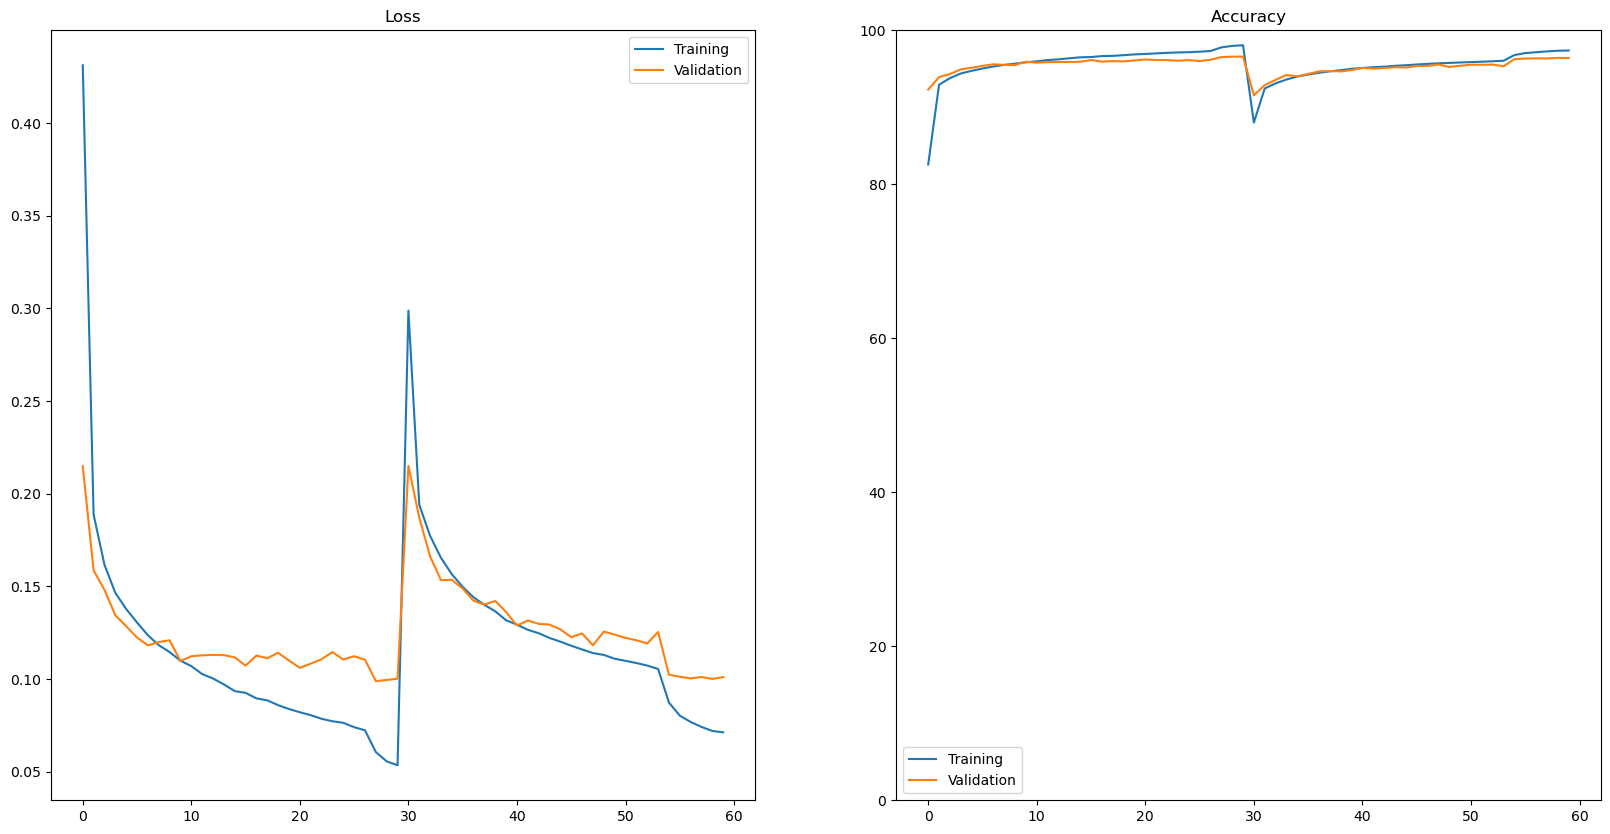

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

ax1.plot(train_losses, label='Training') 
ax1.plot(val_losses, label='Validation')
ax1.legend()
ax1.set_title('Loss')

ax2.plot(train_accuracies, label='Training')
ax2.plot(val_accuracies, label='Validation') 
ax2.legend()
ax2.set_title('Accuracy')
ax2.set_ylim(0, 100)
fig.savefig('./resamplesk_ingredients101/allergens/epochs-dropout0.5-1e-4/FineTunedResNet_allergens_loss_accuracy.png')
plt.show()

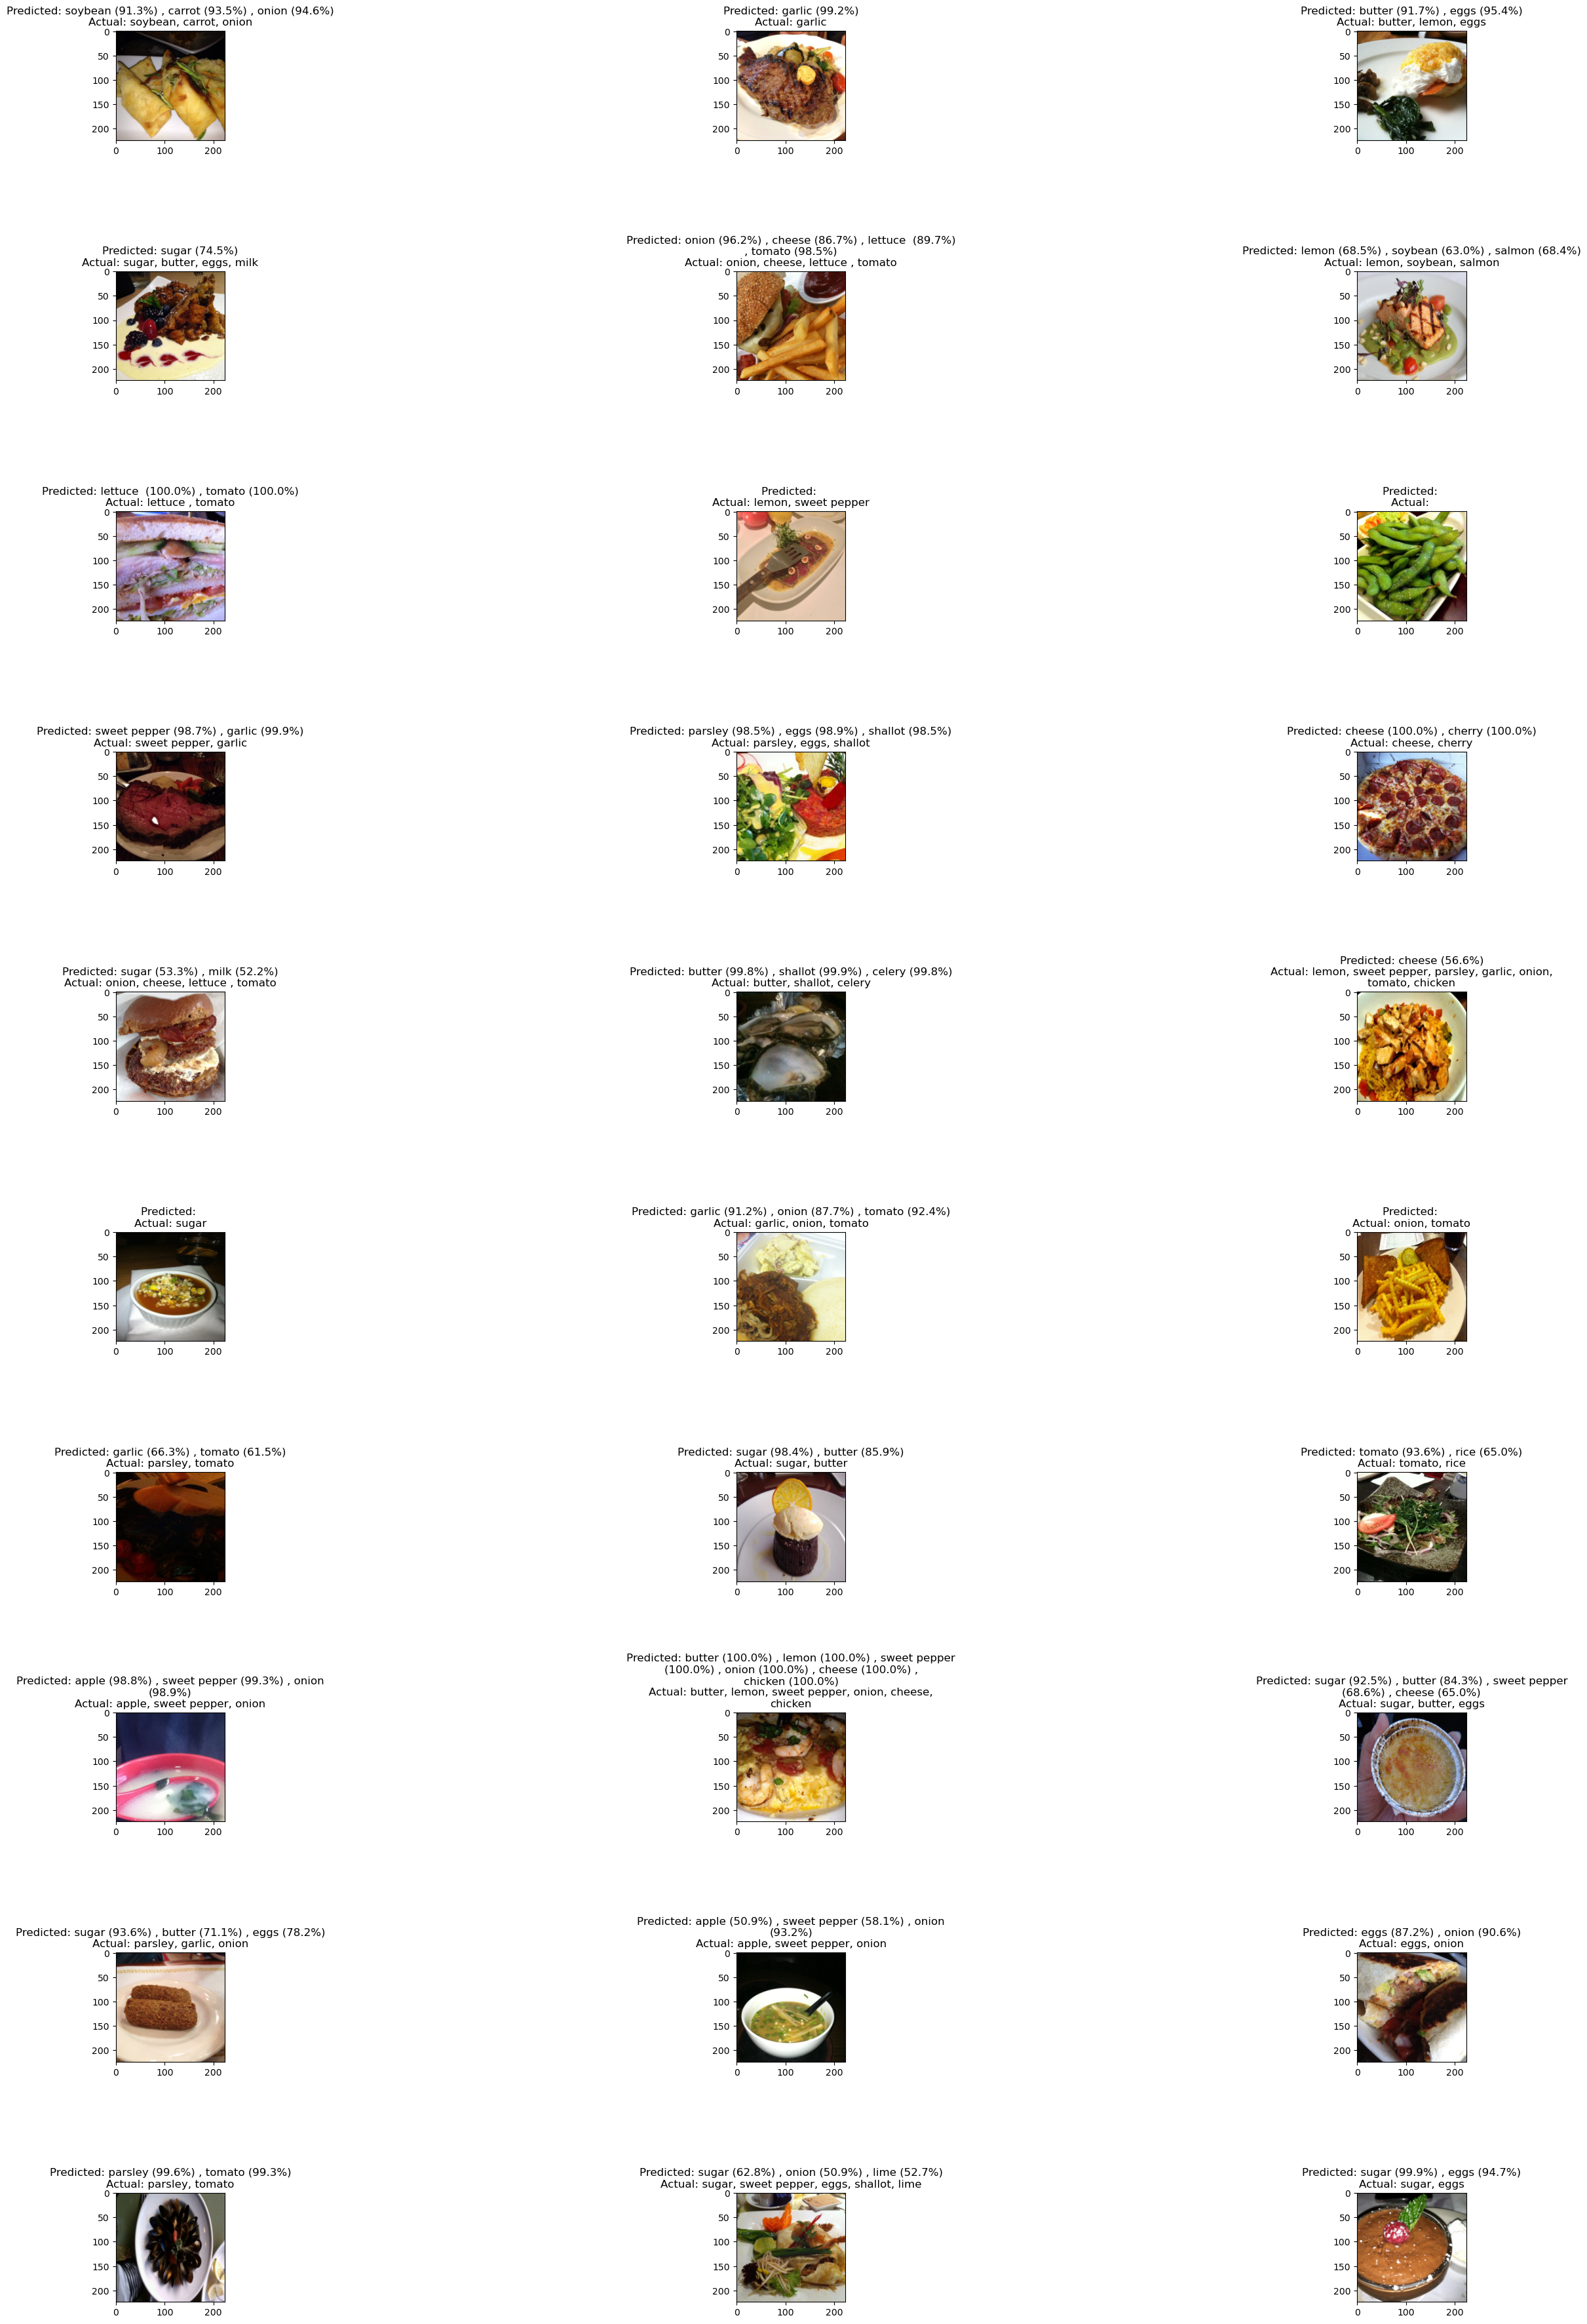

In [ ]:
inputs, targets = next(iter(test_loader))
inputs, targets = inputs.float().to(mps_device), targets.to(mps_device)

# Make predictions 
outputs = model(inputs)
fig, (m_axs) = plt.subplots(10, 3, figsize=(30, 45), gridspec_kw={'hspace': 1.2, 'wspace': 1.2})
for i, c_ax in enumerate(m_axs.flatten()):
    pred_title = ', '.join(['{} ({:2.1f}%)\n'.format(allergens[j], 100 * torch.sigmoid(outputs[i, j]).item())
                            for j, v in enumerate(outputs[i])
                            if torch.sigmoid(v) > 0.5])
    wrapped_pred = '\n'.join(textwrap.wrap(pred_title, width=50))

    act_title = ', '.join(['{}'.format(allergens[j]) for j, v in enumerate(targets[i]) if v == 1.0])
    wrapped_act = '\n'.join(textwrap.wrap(act_title, width=50))
    
    img = inputs[i].permute(1, 2, 0).cpu()
    c_ax.imshow(img)
    title = "Predicted: {}\nActual: {}".format(wrapped_pred, wrapped_act)
    c_ax.set_title(title)

In [ ]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/\
                    float( len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [ ]:
for param in model.parameters():
    param.requires_grad = False
true_labels = []
predicted_labels = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm.tqdm(test_loader, desc='Testing'):
        images, labels = images.to(mps_device), labels.to(mps_device)
        predictions = model(images)
        
        binary_predictions = (predictions > 0.6).cpu().numpy().astype(int)
        
        predicted_labels.extend(binary_predictions)
        true_labels.extend(labels.cpu().numpy())
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

report = classification_report(true_labels, predicted_labels, target_names=allergens, zero_division=0)
print(report)

f1score_samples = f1_score(y_true=true_labels, y_pred=predicted_labels, average='samples')
f1score_macro = f1_score(y_true=true_labels, y_pred=predicted_labels, average='macro')
f1score_weighted = f1_score(y_true=true_labels, y_pred=predicted_labels, average='weighted')
recall = recall_score(y_true=true_labels, y_pred=predicted_labels, average='samples')
prec = precision_score(y_true=true_labels, y_pred=predicted_labels, average='samples')
hamming = hamming_score(y_true=true_labels, y_pred=predicted_labels)


accuracy = accuracy_score(true_labels, predicted_labels)
hl = hamming_loss(true_labels, predicted_labels)
print("Accuracy: ", accuracy)
print("F1 Samples: ", f1score_samples)
print("F1 Weighted: ", f1score_weighted)
print("Hamming score: ", hamming)
print("Hamming loss: ", hl)

Testing:   0%|          | 0/395 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       sugar       0.92      0.89      0.90      7750
       apple       0.94      0.60      0.73      1000
      butter       0.91      0.81      0.86      7000
       lemon       0.90      0.71      0.80      3000
       honey       0.90      0.73      0.81      1000
sweet pepper       0.91      0.78      0.84      5250
     parsley       0.92      0.75      0.83      3000
        eggs       0.90      0.83      0.86      8500
     shallot       0.89      0.80      0.84      1500
     spinach       0.90      0.72      0.80       500
        milk       0.89      0.72      0.80      3250
     soybean       0.92      0.78      0.84      2750
      carrot       0.93      0.82      0.87      1500
      garlic       0.91      0.76      0.83      5000
       onion       0.92      0.78      0.84      7250
      cheese       0.91      0.77      0.83      5500
    lettuce        0.93      0.74      0.82      1250
      almond       0.93    

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1757: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy:  0.6824554455445545
F1 Samples:  0.7623938999782331
F1 Weighted:  0.8382628819733267
Hamming score:  0.7484155486977269
Hamming loss:  0.029065706570657067


/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
torch.save(model.state_dict(), './resamplesk_ingredients101/allergens/epochs-dropout0.5-1e-4/FineTunedResNet_allergens_model_3e-4.pth')

In [ ]:
import pickle
loss_history = {'train_losses': train_losses, 'val_losses': val_losses}
with open('./resamplesk_ingredients101/allergens/epochs-dropout0.5-1e-4/FineTunedResNet_allergens_history.pkl', 'wb') as file:
    pickle.dump(loss_history, file)